# Part 1 : Read Fiji NWP Data
To read data from WRF is quite different than GFS, you can use xarray directly to read the data but it will give you direct output of the model with coordinates originally from WRF (sigma level). To make it easier we will use wrf-python module. if you havent installed it you can do:<br>
<code>pip install wrf-python

## Read one file at a time

In [15]:
import wrf
from netCDF4 import Dataset
from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim, ALL_TIMES, extract_vars
import os
import numpy as np

In [90]:
file_path = 'D:/Projects/fiji-training-2024/data/wrf/'
filename = "wrfout_d02_2024-06-24_00_00_00"

get the diagnostic variable using getvar, for full list of the variable you can refer to this resource:<br>
<a href='https://wrf-python.readthedocs.io/en/latest/diagnostics.html#diagnostic-table'> Table of Available Diagnostics </a>

In [94]:
ncfile = Dataset(os.path.join(file_path,filename))
slp = getvar(ncfile,'slp')

In [36]:
slp['Time']

<xarray.DataArray 'Time' ()>
array('2024-06-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    XTIME    float32 0.0
    Time     datetime64[ns] 2024-06-24

In [39]:
# to see the model resolution
slp['XLAT'][1][0]-slp['XLAT'][0][0]

<xarray.DataArray 'XLAT' ()>
array(0.02552795, dtype=float32)
Coordinates:
    XLONG    float32 173.9
    XTIME    float32 0.0
    Time     datetime64[ns] 2024-06-24

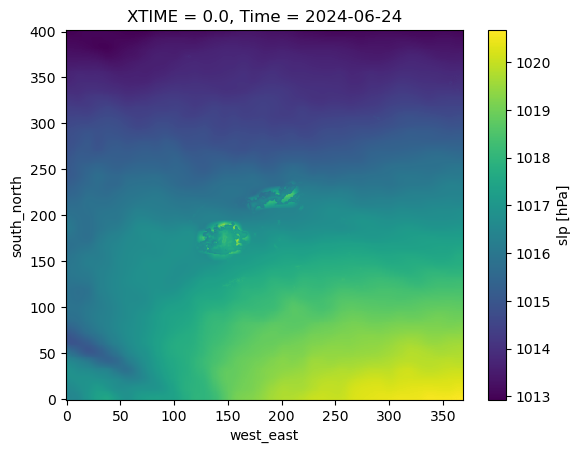

In [37]:
slp.plot()

## Open all files
Open all files in the directory and append it to one data in a time index

In [100]:
file_path = 'D:/Projects/fiji-training-2024/data/wrf/'

In [101]:
ncfiles = [Dataset(f"{file_path}{filename}") for filename in os.listdir(file_path)]
ncfiles

[<class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF4 data model, file format HDF5):
     TITLE:  OUTPUT FROM WRF V4.4.1 MODEL
     START_DATE: 2024-06-24_00:00:00
     SIMULATION_START_DATE: 2024-06-24_00:00:00
     WEST-EAST_GRID_DIMENSION: 370
     SOUTH-NORTH_GRID_DIMENSION: 403
     BOTTOM-TOP_GRID_DIMENSION: 45
     DX: 3000.0
     DY: 3000.0
     AERCU_OPT: 0
     AERCU_FCT: 1.0
     IDEAL_CASE: 0
     DIFF_6TH_SLOPEOPT: 0
     AUTO_LEVELS_OPT: 2
     DIFF_6TH_THRESH: 0.1
     DZBOT: 50.0
     DZSTRETCH_S: 1.1
     DZSTRETCH_U: 1.1
     SKEBS_ON: 0
     USE_Q_DIABATIC: 0
     GRIDTYPE: C
     DIFF_OPT: 2
     KM_OPT: 4
     DAMP_OPT: 3
     DAMPCOEF: 0.2
     KHDIF: 0.0
     KVDIF: 0.0
     MP_PHYSICS: 6
     RA_LW_PHYSICS: 4
     RA_SW_PHYSICS: 4
     SF_SFCLAY_PHYSICS: 91
     SF_SURFACE_PHYSICS: 2
     BL_PBL_PHYSICS: 1
     CU_PHYSICS: 16
     SF_LAKE_PHYSICS: 0
     SURFACE_INPUT_SOURCE: 3
     SST_UPDATE: 0
     GHG_INPUT: 1
     GRID_FDDA: 0
     GFDDA_INTERVAL_M: 0
  

In [102]:
# Extract the 'slp' variable for all times
slp = getvar(ncfiles, "slp", timeidx=wrf.ALL_TIMES, method="cat")

In [103]:
slp

<xarray.DataArray 'slp' (south_north: 402, west_east: 369)>
array([[1016.5263 , 1016.5218 , 1016.519  , ..., 1020.6636 , 1020.66724,
        1020.67065],
       [1016.5132 , 1016.50885, 1016.5059 , ..., 1020.6389 , 1020.6423 ,
        1020.64496],
       [1016.50385, 1016.4985 , 1016.49585, ..., 1020.61554, 1020.618  ,
        1020.621  ],
       ...,
       [1012.9518 , 1012.95215, 1012.9541 , ..., 1013.07715, 1013.0765 ,
        1013.0761 ],
       [1012.94055, 1012.9415 , 1012.9433 , ..., 1013.061  , 1013.06036,
        1013.0603 ],
       [1012.93054, 1012.93207, 1012.9343 , ..., 1013.0451 , 1013.0448 ,
        1013.0451 ]], dtype=float32)
Coordinates:
    XLONG     (south_north, west_east) float32 173.9 174.0 ... -175.9 -175.9
    XLAT      (south_north, west_east) float32 -22.32 -22.32 ... -11.75 -11.75
    XTIME     float64 0.0
    Time      datetime64[ns] 2024-06-24
    datetime  datetime64[ns] 2024-06-24
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  sea level pressure
    units:        hPa
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   Mercator(stand_lon=-164.9530029296875, moad_cen_lat=-12.105...

See that "TIME" value is having 25 values.

Lets make it into a function so you can easily call it

In [10]:
def load_one_wrf(filename: str, varname: str):
    """
    Load a variable from a WRF file.
    
    Parameters:
    filename : str
        Path to the WRF file.
    varname : str
        Variable name to extract.
    
    Returns:
    xr.DataArray
        The extracted variable as an xarray DataArray.
    
    Raises:
    FileNotFoundError
        If the specified file does not exist.
    """
    # Check if the file exists
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File {filename} not found")
    
    # Open the file
    ncfile = Dataset(filename)
    
    # Extract the variable
    var = getvar(ncfile, varname)
    
    return var

# Usage example
filename = 'D:/Projects/fiji-training-2024/data/wrf/wrfout_d02_2024-06-24_00_00_00'
slp = load_one_wrf(filename, 'slp')
slp

<xarray.DataArray 'slp' (south_north: 402, west_east: 369)>
array([[1016.5263 , 1016.5218 , 1016.519  , ..., 1020.6636 , 1020.66724,
        1020.67065],
       [1016.5132 , 1016.50885, 1016.5059 , ..., 1020.6389 , 1020.6423 ,
        1020.64496],
       [1016.50385, 1016.4985 , 1016.49585, ..., 1020.61554, 1020.618  ,
        1020.621  ],
       ...,
       [1012.9518 , 1012.95215, 1012.9541 , ..., 1013.07715, 1013.0765 ,
        1013.0761 ],
       [1012.94055, 1012.9415 , 1012.9433 , ..., 1013.061  , 1013.06036,
        1013.0603 ],
       [1012.93054, 1012.93207, 1012.9343 , ..., 1013.0451 , 1013.0448 ,
        1013.0451 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 173.9 174.0 ... -175.9 -175.9
    XLAT     (south_north, west_east) float32 -22.32 -22.32 ... -11.75 -11.75
    XTIME    float32 0.0
    Time     datetime64[ns] 2024-06-24
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  sea level pressure
    units:        hPa
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   Mercator(stand_lon=-164.9530029296875, moad_cen_lat=-12.105...

In [19]:
def load_all_wrf(folder_path: str, varname: str):
    """
    Load a variable from all WRF files in a folder and concatenate them over time.

    Parameters:
    folder_path : str
        Path to the folder containing the WRF files.
    varname : str
        Variable name to extract.

    Returns:
    xr.DataArray
        The concatenated variable over time from all WRF files.

    Raises:
    FileNotFoundError
        If the specified folder does not exist or contains no WRF files.
    ValueError
        If no valid WRF files are found in the specified folder.
    """
    # Check if the folder exists
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f"Folder {folder_path} not found")

    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Filter for valid NetCDF files
    nc_files = [os.path.join(folder_path, f) for f in files if f.startswith('wrfout')]
    
    # Check if there are any NetCDF files in the folder
    if not nc_files:
        raise ValueError(f"No NetCDF files found in folder {folder_path}")
    
    # Open all NetCDF files
    ncfiles = [Dataset(file) for file in nc_files]
    
    # Extract and concatenate the variable over time
    var = getvar(ncfiles, varname, timeidx=wrf.ALL_TIMES, method="cat")
    
    return var

# Usage example
folder_path = 'D:/Projects/fiji-training-2024/data/wrf/'
slp = load_all_wrf(folder_path, 'slp')

ValueError: 'sl' is not a valid variable name